<h1>**IBM Model 1**</h1>

1. a) Implement EM training (Brown et al., 1993) for IBM model 1; <br />
    b) Implement variational inference for Bayesian IBM model 1; <br />
    c) All of the tasks below should be performed for both models.<br />
2. Plot the evolution of training log likelihood (or ELBO) as a function of the iteration.
3. Plot the evolution of alignment error rate (AER) on validation data as a function of the iteration;
4. Experiment with two criteria for model selection (i.e. deciding on number of training iterations): 
    1) convergence in terms of training log likelihood; 
    2) best AER on validation data;
5. For the selected models, obtain Viterbi alignments for every sentence pair in a test
corpus and compute AER using a gold-standard provided by the assistant;

In [9]:
import aer
from collections import defaultdict, Counter
from math import log2
import numpy as np
from random import randint
import progressbar
import matplotlib.pyplot as plt
from scipy.special import digamma, gammaln 

In [4]:
def read_corpus(file_name, source_language):
    """
    Reads the corpus and saves each sentence in a list.
    """
    
    corpus = []
    
    with open(file_name, "r", encoding='utf8') as f:
        for line in f:
            line = line.replace("\n", "")
            sentence = line.split()
            
            if source_language:
                sentence.insert(0, "null")
            corpus.append(sentence)
    return corpus[:2000]


def reduce_corpus(corpus):
    """
    Reduces the vocabulary of the corpus by replacing each word that only
    occurs once in the vocabulary by -LOW- in the corpus.
    """
    
    flat_corpus = [word for sentence in corpus for word in sentence]
    word_counts = Counter(flat_corpus)
    small_corpus = []
    
    for sentence in corpus:
        small_sentence = []
        
        for word in sentence:
            if word_counts[word] != 1:
                small_sentence.append(word)
            else:
                small_sentence.append("-LOW-")
        small_corpus.append(small_sentence)
    return small_corpus

    
train_source = read_corpus("training/hansards.36.2.e", True)
train_source = reduce_corpus(train_source)
print("Read training source corpus")
train_target = read_corpus("training/hansards.36.2.f", False)
train_target = reduce_corpus(train_target)
print("Read training target corpus")
val_source = read_corpus("validation/dev.e", True)
val_target = read_corpus("validation/dev.f", False)
print("Read validation corpora")

Read training source corpus
Read training target corpus
Read validation corpora


In [6]:
def initialise_parameters(source_corpus, target_corpus):
    """
    Initialises the conditional probability of generating a source 
    word from a target word for all possible pairs of words in the source 
    and target sentences to 5 and then normalises the parameters such that 
    the initialisation is uniform.
    """
    
    flat_corpus = [word for sentence in source_corpus for word in sentence]
    amount_source_words = len(set(flat_corpus))
    theta0 = 1/amount_source_words
    return defaultdict(lambda: defaultdict(lambda: theta0))


def expectation_maximisation(train_source, train_target, val_source,
                             val_target, parameters, num_iterations, 
                             min_perplexity_change):
    """
    Do the EM algorithm until perplexity decreases very little or until 
    the number of iterations is reached.
    """
    
    old_perplexity = -100000
    perplexities = []
    aers = []
    
    for k in range(0, num_iterations):
        print("Iteration #" + str(k), "out of", num_iterations - 1)
        counts_single = defaultdict(lambda: 1.0)
        counts_pairs = defaultdict(lambda: defaultdict(float))
        counts_single, counts_pairs = e_step(train_source, train_target,
                                             parameters, counts_single, 
                                             counts_pairs)
        parameters = m_step(parameters, counts_single, counts_pairs)
        perplexity = compute_perplexity(parameters, train_source, train_target)
        alignments = get_best_alignment(val_source, val_target, parameters)
        aers.append(compute_aer(alignments))
        perplexities.append(perplexity)
        
        if abs(perplexity - old_perplexity) < min_perplexity_change:
            return perplexities, aers
        else:
            old_perplexity = perplexity
    return perplexities, aers
    
    
def e_step(source_corpus, target_corpus, parameters, counts_single, 
           counts_pairs):
    """
    Do the E-step by computing the expected counts.
    """
    
    print("Doing E-step...")
    
    with progressbar.ProgressBar(max_value=len(target_corpus)) as bar:
        for n in range(len(target_corpus)):
            target_sentence = target_corpus[n]
            source_sentence = source_corpus[n]

            for i in range(len(target_sentence)):
                normalisation_term = 0
                target_word = target_sentence[i]

                for j in range(len(source_sentence)):
                    source_word = source_sentence[j]
                    normalisation_term += parameters[source_word][target_word]
                for j in range(len(source_sentence)):
                    source_word = source_sentence[j]
                    expected_count = parameters[source_word][target_word]/normalisation_term
                    counts_pairs[source_word][target_word] += expected_count
                    counts_single[source_word] += expected_count
            bar.update(n)
    return counts_single, counts_pairs


def m_step(parameters, counts_single, counts_pairs):
    """
    Do the M-step by normalising the parameters.
    """
    
    print("Doing M-step...")
    
    with progressbar.ProgressBar(max_value=len(counts_pairs)) as bar:
        i = 0
        for source_word, target_words in counts_pairs.items():
            for target_word, expected_count in target_words.items():
                parameters[source_word][target_word] = expected_count/counts_single[source_word]
            i += 1
            bar.update(i)
    return parameters


def compute_perplexity(theta_dict, source_corpus, target_corpus):
    """
    Computes the perplexity of the corpus.
    """
    
    logprobs = []
    total_sum = 0
    
    for n in range(len(source_corpus)):
        english_sentence = source_corpus[n]
        french_sentence = target_corpus[n]
        french_sum = 0
        for j in range(len(french_sentence)): 
            f_j = french_sentence[j]
            log_sum = []
            for i in range(len(english_sentence)): 
                e_i = english_sentence[i]
                log_sum.append(theta_dict[e_i][f_j])
            french_sum += np.log(np.sum(log_sum))
        total_sum += french_sum
    perplexity = total_sum
    print(perplexity)
    return perplexity


def calculate_likelihood(source_corpus, target_corpus, parameters):
    """
    Calculates the likelihood over te corpus:
    sum_<f,e> sum^m_i=1 log sum^l_j=0 pi_t(target|source) 
    """
    
    corpus_likelihood = 0
    
    for n in range(len(source_corpus)):
        source_sentence = source_corpus[n]
        target_sentence = target_corpus[n]
        target_likelihood = 0
        
        for i in range(len(target_sentence)):
            target_word = target_sentence[i]
            source_likelihood = 0
            
            for j in range(len(source_sentence)):
                source_word = source_sentence[j]
                source_likelihood += parameters[source_word][target_word]
            target_likelihood += log2(source_likelihood)
        corpus_likelihood += target_likelihood
    return corpus_likelihood
   
    
def get_best_alignment(source_corpus, target_corpus, parameters):
    """
    Gets the best alignment for each sentence and saves the alignment
    in a list of lists that holds tuples for each position in the sentence
    and looks as follows:
    (sentence_index, target_word_index, source_word_index).
    """
    
    alignments = []
    
    for n in range(len(source_corpus)):
        source_sentence = source_corpus[n]
        target_sentence = target_corpus[n]
        alignment = []
        
        for i in range(len(target_sentence)):
            target_word = target_sentence[i]
            best_prob = 0
            best_j = 0
            
            for j in range(len(source_sentence)):
                source_word = source_sentence[j]
                prob = parameters[source_word][target_word]
                
                if prob > best_prob:
                    best_prob = prob
                    best_j = j
                    
            if best_j != 0:    
                alignment.append((n, best_j, i+1))
        alignments.append(alignment)
    return alignments


def compute_aer(predictions):
    """
    Computes the Alignment Error Rate.
    """
    
    gold_sets = aer.read_naacl_alignments("validation/dev.wa.nonullalign")
    metric = aer.AERSufficientStatistics()
    
    for gold, prediction in zip(gold_sets, predictions):
        prediction = set([(alignment[1], alignment[2]) for alignment in prediction])
        metric.update(sure=gold[0], probable=gold[1], predicted=prediction)
    print(metric.aer())
    return metric.aer()
    
print("Initialising parameters...")
initial_params = initialise_parameters(train_source, train_target)
perplexities, aers = expectation_maximisation(train_source, train_target, 
                                              val_source, val_target,
                                              initial_params, 10, 5)

  7% (152 of 2000) |#                     | Elapsed Time: 0:00:00 ETA:  0:00:01

Initialising parameters...
Iteration #0 out of 9
Doing E-step...


100% (2000 of 2000) |#####################| Elapsed Time: 0:00:02 Time: 0:00:02
100% (2444 of 2444) |#####################| Elapsed Time: 0:00:00 Time: 0:00:00


Doing M-step...


  7% (152 of 2000) |#                     | Elapsed Time: 0:00:00 ETA:  0:00:01

-48081.10720249418
0.518597236981934
Iteration #1 out of 9
Doing E-step...


100% (2000 of 2000) |#####################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (2444 of 2444) |#####################| Elapsed Time: 0:00:00 Time: 0:00:00


Doing M-step...


 11% (228 of 2000) |##                    | Elapsed Time: 0:00:00 ETA:  0:00:01

-29819.011814967555
0.4720430107526882
Iteration #2 out of 9
Doing E-step...


100% (2000 of 2000) |#####################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (2444 of 2444) |#####################| Elapsed Time: 0:00:00 Time: 0:00:00


Doing M-step...


 13% (279 of 2000) |###                   | Elapsed Time: 0:00:00 ETA:  0:00:01

-22276.970188187643
0.47634408602150535
Iteration #3 out of 9
Doing E-step...


100% (2000 of 2000) |#####################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (2444 of 2444) |#####################| Elapsed Time: 0:00:00 Time: 0:00:00


Doing M-step...


 10% (203 of 2000) |##                    | Elapsed Time: 0:00:00 ETA:  0:00:01

-18854.614461847737
0.48064516129032253
Iteration #4 out of 9
Doing E-step...


100% (2000 of 2000) |#####################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (2444 of 2444) |#####################| Elapsed Time: 0:00:00 Time: 0:00:00


Doing M-step...


  8% (178 of 2000) |#                     | Elapsed Time: 0:00:00 ETA:  0:00:01

-17127.542810965362
0.43795620437956206
Iteration #5 out of 9
Doing E-step...


100% (2000 of 2000) |#####################| Elapsed Time: 0:00:02 Time: 0:00:02
100% (2444 of 2444) |#####################| Elapsed Time: 0:00:00 Time: 0:00:00


Doing M-step...


  7% (152 of 2000) |#                     | Elapsed Time: 0:00:00 ETA:  0:00:01

-16148.955744870631
0.43169968717413976
Iteration #6 out of 9
Doing E-step...


100% (2000 of 2000) |#####################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (2444 of 2444) |#####################| Elapsed Time: 0:00:00 Time: 0:00:00


Doing M-step...


 11% (228 of 2000) |##                    | Elapsed Time: 0:00:00 ETA:  0:00:00

-15542.8407332105
0.4369134515119917
Iteration #7 out of 9
Doing E-step...


100% (2000 of 2000) |#####################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (2444 of 2444) |#####################| Elapsed Time: 0:00:00 Time: 0:00:00


Doing M-step...


  8% (178 of 2000) |#                     | Elapsed Time: 0:00:00 ETA:  0:00:01

-15142.57322907176
0.44525547445255476
Iteration #8 out of 9
Doing E-step...


100% (2000 of 2000) |#####################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (2444 of 2444) |#####################| Elapsed Time: 0:00:00 Time: 0:00:00


Doing M-step...


  8% (178 of 2000) |#                     | Elapsed Time: 0:00:00 ETA:  0:00:01

-14865.677348182091
0.45151199165797706
Iteration #9 out of 9
Doing E-step...


100% (2000 of 2000) |#####################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (2444 of 2444) |#####################| Elapsed Time: 0:00:00 Time: 0:00:00


Doing M-step...
-14667.239343214545
0.45359749739311783


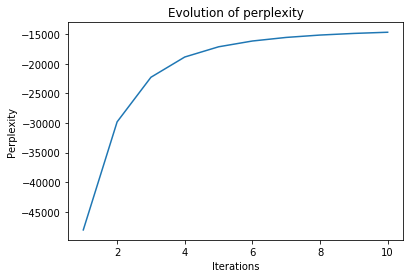

In [17]:
plt.plot(np.arange(1, len(perplexities)+1), perplexities)
plt.title("Evolution of perplexity")
plt.xlabel("Iterations")
plt.ylabel("Perplexity")
plt.show()



<h1>IBM Model 2</h1>

In [16]:
iterations = 10
sub = 1


def expectation_maximisation2(source_corpus, target_corpus, parameters, num_iterations, min_perplexity_change):
    q = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0.1))))
    old_perplexity = -100000
    
    for k in range(0, num_iterations):
        print("Iteration #" + str(k), "out of", num_iterations - 1)
        
        counts_pairs = defaultdict(lambda: defaultdict(lambda: 0.))
        counts_alignments = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0.))))
        counts_single = defaultdict(lambda: 0.)
        counts_pairs, counts_single, counts_alignments = e_step2(source_corpus, target_corpus, counts_pairs, counts_single, counts_alignments, q)
        parameters, q = m_step2(parameters, q, counts_alignments, counts_pairs, counts_single)
        perplexity = compute_perplexity(parameters, source_corpus, target_corpus)
        print(perplexity)
        
        if abs(perplexity - old_perplexity) < min_perplexity_change:
            return parameters
        else:
            old_perplexity = perplexity
    return parameters        


def e_step2(source_corpus, target_corpus, counts_pairs, counts_single, counts_alignments, q):
    for n in range(len(source_corpus)):
        source_sentence = source_corpus[n]
        target_sentence = target_corpus[n]
        l = len(source_sentence)
        m = len(target_sentence)

        for i, target_word in enumerate(target_sentence):
            delta_denominator = sum([q[j_k][i][l][m]*parameters[source_sentence[j_k]][target_word] for j_k in range(l)])

            for j, source_word in enumerate(source_sentence):
                delta = (q[j][i][l][m]*parameters[source_word][target_word]) / delta_denominator

                counts_pairs[source_word][target_word] += delta
                counts_single[source_word] += delta
                counts_alignments[l][m][i][j] += delta
    return counts_pairs, counts_single, counts_alignments


def m_step2(parameters, q, counts_alignments, counts_pairs, counts_single):
    for j in q.keys():
        for i in q[j].keys():
            for l in q[j][i].keys():
                for m in q[j][i][l].keys():
                    q[j][i][l][m] = counts_alignments[l][m][i][j] / sum(counts_alignments[l][m][i].values())
    
    for source_word, target_words in parameters.items():
        for target_word in target_words:
            parameters[source_word][target_word] = counts_pairs[source_word][target_word]/counts_single[source_word]
    return parameters, q


parameters = initialise_parameters(train_source_corpus, train_target_corpus)
parameters = expectation_maximisation2(train_source_corpus, train_target_corpus, parameters, 
                                       10, 5)
alignments = get_best_alignment(val_source_corpus, val_target_corpus, parameters)
compute_aer(alignments)

# q = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0.1))))
# perps = []

# for s in range(iterations):
    
#     print('iteration', s)
#     # initialize all counts to 0
    
#     counts_pairs = defaultdict(lambda: defaultdict(lambda: 0.))
#     counts_alignments = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0.))))
#     counts_single = defaultdict(lambda: 0.)
    
#     for n in range(len(train_source_corpus)):
#         source_sentence = train_source_corpus[n]
#         target_sentence = train_target_corpus[n]
#         l = len(source_sentence)
#         m = len(target_sentence)

#         for i, target_word in enumerate(target_sentence):
#             delta_denominator = sum([q[j_k][i][l][m]*parameters[source_sentence[j_k]][target_word] for j_k in range(l)])
            
#             for j, source_word in enumerate(source_sentence):
#                 delta = (q[j][i][l][m]*parameters[source_word][target_word]) / delta_denominator
                
#                 counts_pairs[source_word][target_word] += delta
#                 counts_single[source_word] += delta
#                 counts_alignments[l][m][i][j] += delta
                
#     for j in q.keys():
#         for i in q[j].keys():
#             for l in q[j][i].keys():
#                 for m in q[j][i][l].keys():
#                     q[j][i][l][m] = counts_alignments[l][m][i][j] / sum(counts_alignments[l][m][i].values())
    
#     for source_word, target_words in parameters.items():
#         for target_word in target_words:
#             parameters[source_word][target_word] = counts_pairs[source_word][target_word]/counts_single[source_word]
                
#     perp = compute_perplexity(parameters, train_source_corpus, train_target_corpus)
#     perps.append(perp)

Iteration #0 out of 9
-43825.6879894
Iteration #1 out of 9
-27689.9665298
Iteration #2 out of 9
-17920.2666
Iteration #3 out of 9
-14109.4795137
Iteration #4 out of 9
-13396.0014646
Iteration #5 out of 9
-13721.8589776
Iteration #6 out of 9
-14185.103931
Iteration #7 out of 9
-14544.6924467
Iteration #8 out of 9
-14789.8907897
Iteration #9 out of 9
-14957.5577081
0.4627329192546584


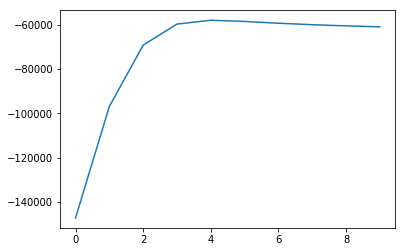

In [19]:
plt.plot(perps)
plt.show()

# Variational Bayes IBM1

In [ ]:
def elbo(theta_dict, lambda_dict, train_source_corpus, traing_target_corpus, alpha):

    elbo_first_term = compute_perplexity(theta_dict, train_source_corpus, train_target_corpus)
    elbo_second_term = 0

    for english_word in english_vocab: 
        normalization = sum([lambda_dict[english_word][french_word] for french_word in french_vocab])
        digamma_normalization = digamma(normalization)
        gammaln_normalization = gammaln(normalization)
        for french_word in french_vocab: 
            first_term = digamma(lambda_dict[english_word][french_word]) - digamma_normalization 
            first_term = first_term * (alpha - lambda_dict[english_word][french_word])
            second_term = gammaln(lambda_dict[english_word][french_word]) 
            third_term = gammaln(alpha)
            fourth_term = gammaln(len(french_vocab) * alpha)
            elbo_second_term += first_term + second_term - third_term + fourth_term - gammaln_normalization

    return elbo_first_term + elbo_second_term


alpha = 1
iterations = 10 

theta_dict = initialise_parameters(train_source_corpus, train_target_corpus)
lambda_dict = initialise_parameters(train_source_corpus, train_target_corpus)

english_vocab = set([word for sentence in train_source_corpus for word in sentence])
french_vocab = set([word for sentence in train_target_corpus for word in sentence])

for i in range(iterations): 
    print(i, 'th iteration out of ', iterations-1)
    counts_single = defaultdict(lambda: 1.0)
    counts_pairs = defaultdict(lambda: defaultdict(float))
    
    # e step
    for n in range(len(train_source_corpus)):
        source_sentence = train_source_corpus[n]
        target_sentence = train_target_corpus[n]
        
        for source_word in source_sentence: 
            normalization = sum([lambda_dict[source_word][target_word] for target_word in target_sentence])
            for target_word in target_sentence: 
                theta_dict[source_word][target_word] = np.exp(digamma(lambda_dict[source_word][target_word]) - \
                                                              digamma(normalization))
    # m step    
    for source_word in english_vocab: 
        target_words = lambda_dict[source_word].keys()
        for target_word in target_words:
            lambda_dict[source_word][target_word] = alpha + theta_dict[source_word][target_word]
    
    elbo_iter = elbo(theta_dict, lambda_dict, train_source_corpus, train_target_corpus, alpha)
    print(elbo_iter)

0 th iteration out of  9


C:\Users\Urja\Anaconda3\lib\site-packages\ipykernel\__main__.py:138: RuntimeWarning: divide by zero encountered in log


In [36]:
import operator 

print(max(lambda_dict['the'].items(), key=operator.itemgetter(1))[0])
lambda_dict['the']['sénateurs']

sénateurs


0.46825060387463785

In [37]:
compute_perplexity(theta_dict, train_source_corpus, train_target_corpus)

-19030.957387138806